*Importing*

In [1]:
import numpy as np
import io
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
#from sklearn import svm

In [2]:
Xtestd = np.genfromtxt(r"C:\Users\shrey\x_test.csv", dtype=float, delimiter=',', skip_header=1)/255 # The final data needs to be scaled from 0 to 1 (if you change this, then do not scale the training data either)

In [3]:
training = imageio.v3.imread(r"C:\Users\shrey\train.gif")

In [4]:
frames_training = training.mean(3)/255

In [5]:
frames_training 

array([[[0.94901961, 0.9254902 , 0.90196078, ..., 0.83137255,
         0.74117647, 0.63529412],
        [0.9372549 , 0.92156863, 0.87058824, ..., 0.84313725,
         0.77647059, 0.70588235],
        [0.89019608, 0.88627451, 0.80392157, ..., 0.85490196,
         0.80784314, 0.7372549 ],
        ...,
        [0.79215686, 0.83137255, 0.70980392, ..., 0.76078431,
         0.74901961, 0.65882353],
        [0.8       , 0.81960784, 0.75294118, ..., 0.76862745,
         0.76078431, 0.65882353],
        [0.58431373, 0.67843137, 0.68627451, ..., 0.79215686,
         0.78823529, 0.72156863]],

       [[0.95686275, 0.92941176, 0.91372549, ..., 0.84705882,
         0.78039216, 0.69019608],
        [0.94117647, 0.9254902 , 0.8745098 , ..., 0.84705882,
         0.8       , 0.74509804],
        [0.90588235, 0.89803922, 0.82352941, ..., 0.85490196,
         0.82352941, 0.76862745],
        ...,
        [0.80784314, 0.83529412, 0.71764706, ..., 0.78431373,
         0.77647059, 0.69411765],
        [0.8

In [6]:
Xte = []
for i in range(1266):
    frame = []
    for j in range(3):
        frame.append(np.reshape((Xtestd[i,1024*j:1024*(j+1)]),(32,32)))
    framef = np.concatenate((frame[0], frame[1], frame[2]), axis = 1)
    Xte.append(framef)
Xte = np.asarray(Xte)

In [7]:
Xte

array([[[0.80784314, 0.84313725, 0.79215686, ..., 0.8       ,
         0.81568627, 0.80392157],
        [0.78823529, 0.82745098, 0.79607843, ..., 0.80392157,
         0.81176471, 0.79215686],
        [0.81568627, 0.84313725, 0.80392157, ..., 0.80392157,
         0.80784314, 0.79215686],
        ...,
        [0.82352941, 0.81568627, 0.81568627, ..., 0.81568627,
         0.81176471, 0.80784314],
        [0.82745098, 0.82745098, 0.81960784, ..., 0.79607843,
         0.80784314, 0.81176471],
        [0.83137255, 0.82745098, 0.82745098, ..., 0.80392157,
         0.80392157, 0.81176471]],

       [[0.74509804, 0.78431373, 0.80392157, ..., 0.8       ,
         0.8       , 0.84313725],
        [0.79607843, 0.81960784, 0.82745098, ..., 0.81960784,
         0.80784314, 0.81568627],
        [0.82352941, 0.83921569, 0.83921569, ..., 0.81960784,
         0.80784314, 0.81176471],
        ...,
        [0.84313725, 0.83137255, 0.82352941, ..., 0.8       ,
         0.78039216, 0.79215686],
        [0.8

***Preprocessing***

*Denoising*

In [8]:
def bgremove(img):
    new_img = []
    for i in range(len(img)):
        row = []
        for j in range(len(img[i])):
            if img[i][j]>0.6:
                row.append(1)
            else:
                row.append(img[i][j])
        new_img.append(row)
    return new_img

In [9]:
denoised_frames_training = []
for i in frames_training:
    denoised_frames_training.append(bgremove(i))

In [10]:
denoised_frames_training = np.array(denoised_frames_training)

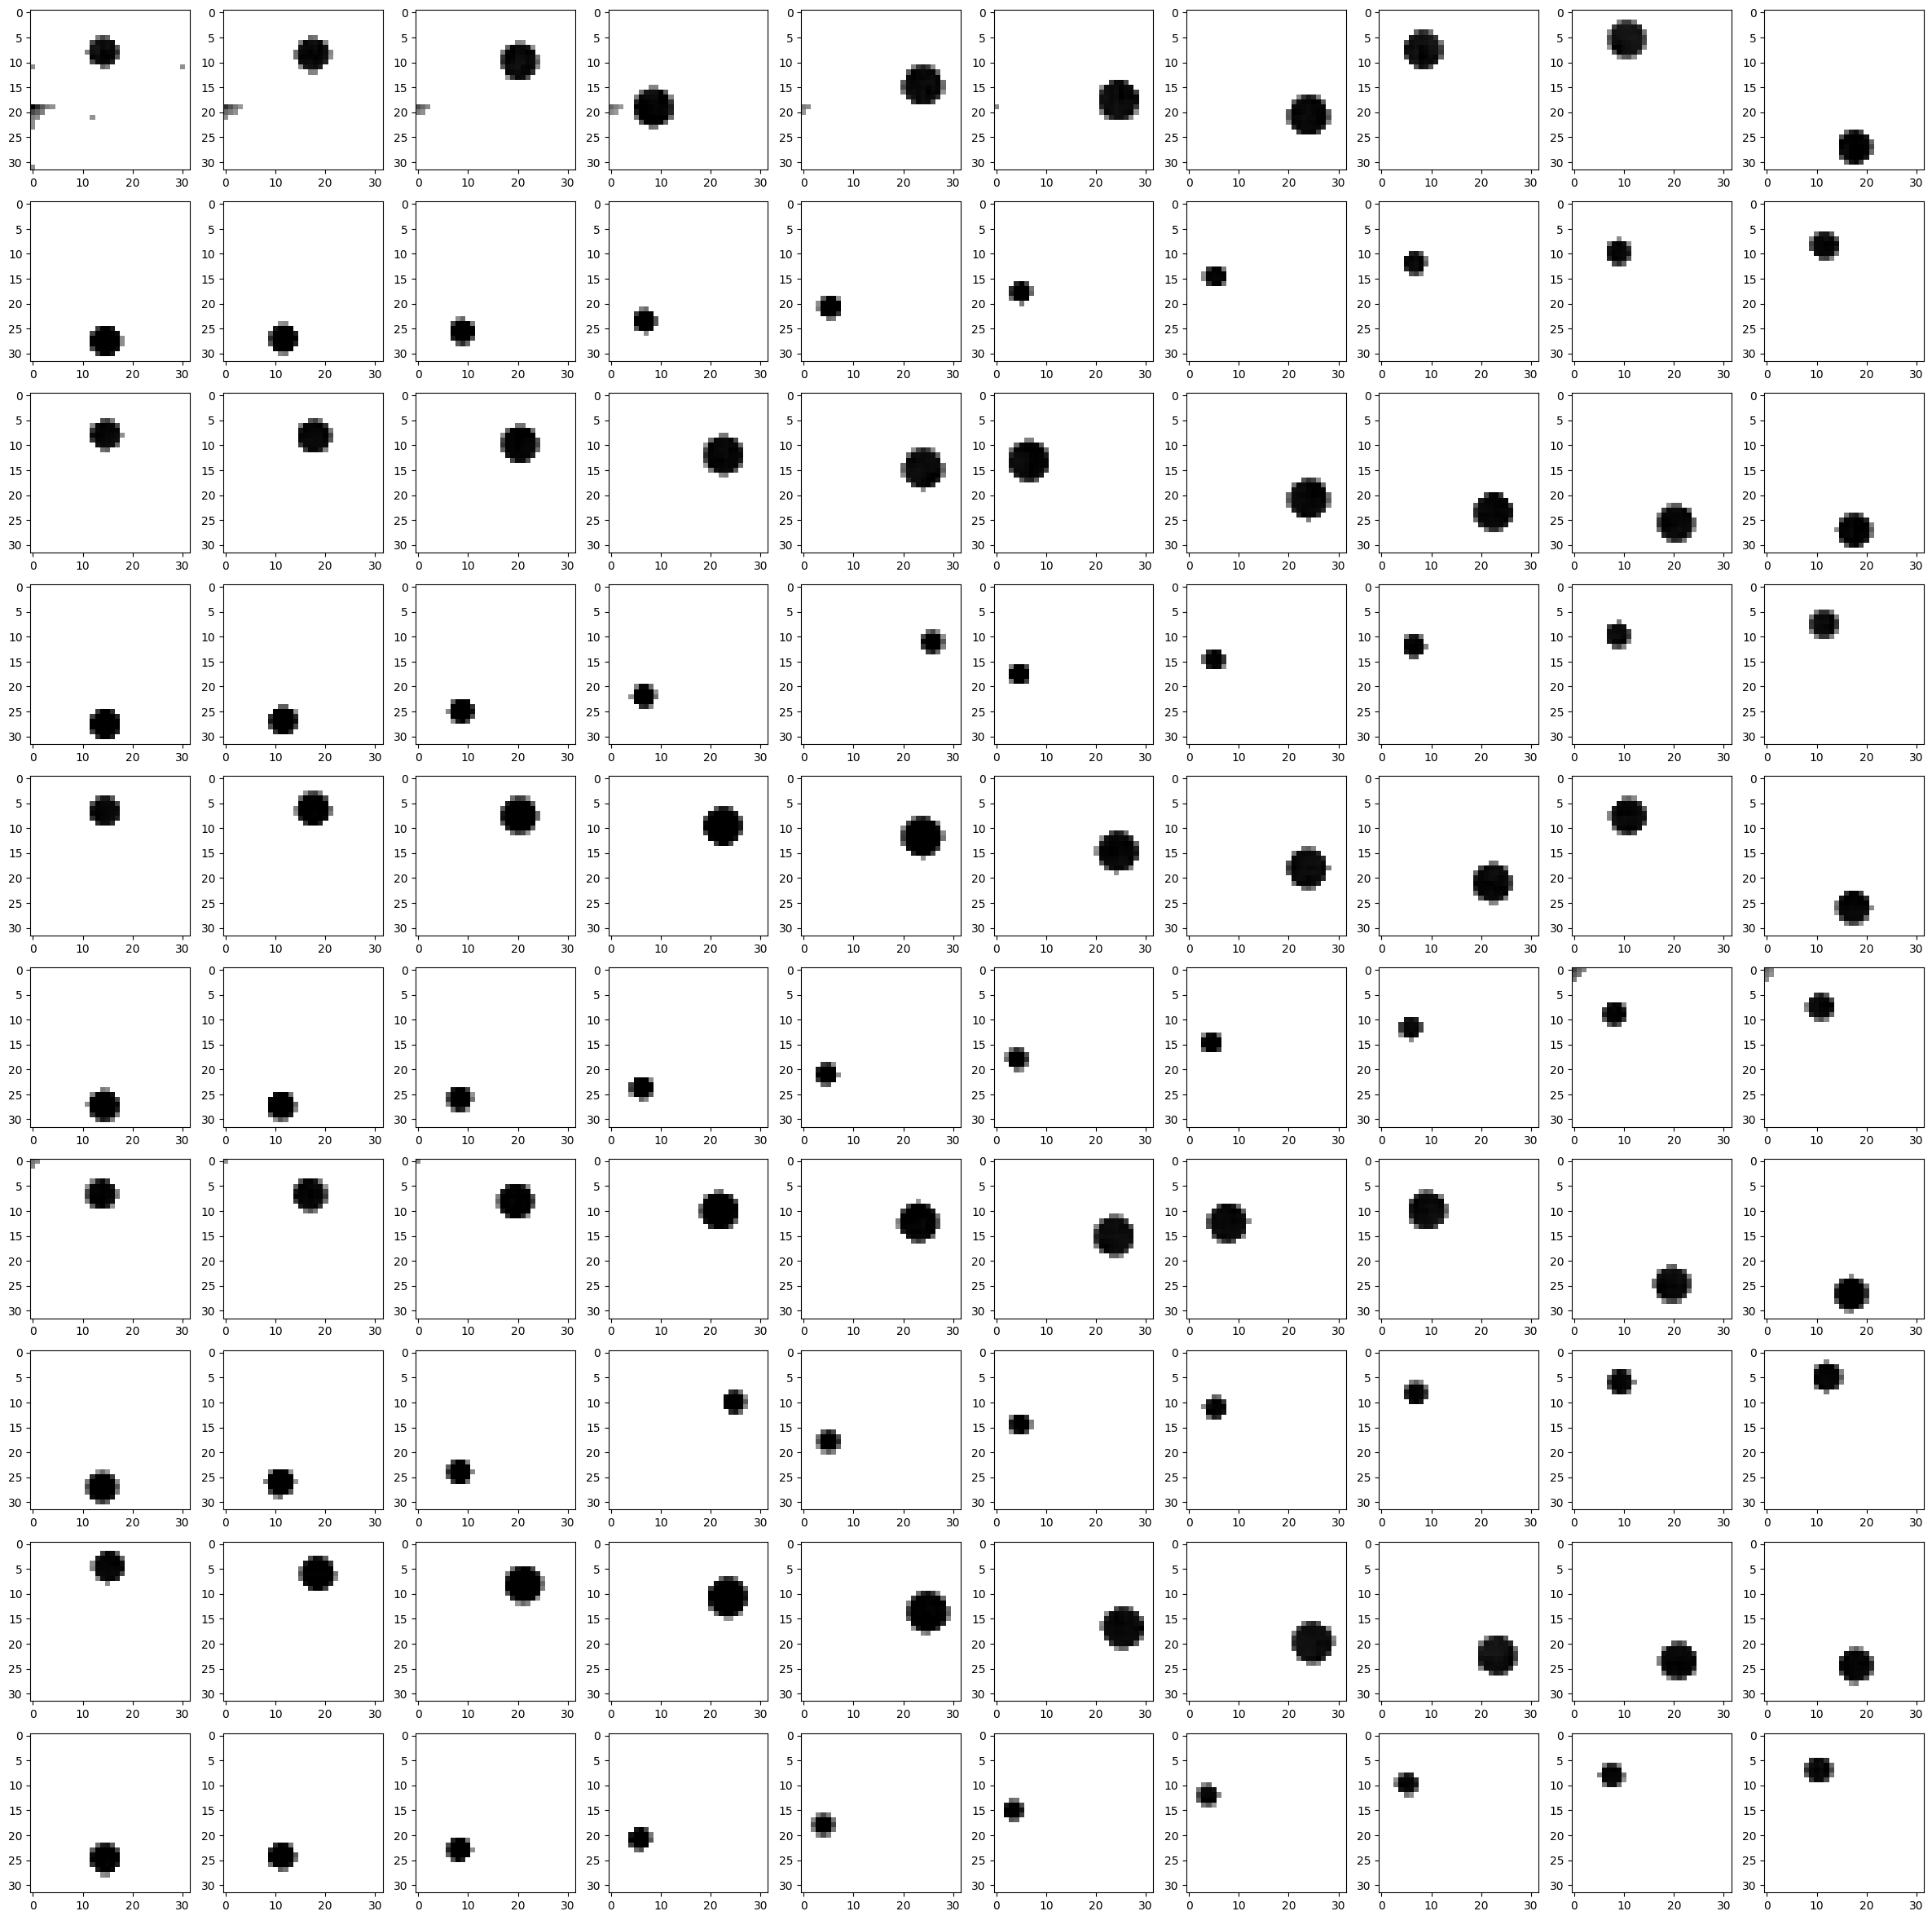

In [11]:
fig, axes = plt.subplots(10, 10, figsize=(30, 30))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(denoised_frames_training):
        ax.imshow(denoised_frames_training[i], cmap='gray')
plt.show()

In [12]:
denoised_test = []
for i in Xte:
    denoised_test.append(bgremove(i))

*Deflickering*

In [13]:
def darkestpixel(img):
    return np.unravel_index(np.argmin(img),  img.shape)

In [14]:
# def centerofcircle(img):
#         xcoord, ycoord = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]))
#         s1 = np.sum(xcoord * img)
#         s2 = np.sum(ycoord * img)
#         total_sum = np.sum(img)
#         x = np.round(s1 / total_sum)
#         y = np.round(s2 / total_sum)
#         return x, y

In [15]:
def lsfit(a, b, c, d, e, f, g, h, i, j):
    a1, a2 = darkestpixel(a)
    b1, b2 = darkestpixel(b)
    c1, c2 = darkestpixel(c)
    d1, d2 = darkestpixel(d)
    e1, e2 = darkestpixel(e)
    f1, f2 = darkestpixel(f)
    g1, g2 = darkestpixel(g)
    h1, h2 = darkestpixel(h)
    i1, i2 = darkestpixel(i)
    j1, j2 = darkestpixel(j)
    x = [a1, b1, c1, d1, e1, f1, g1, h1, i1, j1]
    y = [a2, b2, c2, d2, e2, f2, g2, h2, i2, j2]
    def least_squares_fit(x, y):
        A = np.vstack([x, np.ones(len(x))]).T
        b = y
        coefficients, residuals, _, _ = np.linalg.lstsq(A, b, rcond=None)
        m, c = coefficients
        return m, c
    m, c = least_squares_fit(x, y)
    def pointlinedist(m, c, a, b):
        return abs((m * a) + c - b) / np.sqrt((1 + (m ** 2)))
    dists = [pointlinedist(m, c, x[i], y[i]) for i in range(len(x))]
    avg = np.average(dists)
    std = np.std(dists)
    new_list = []
    for i in dists:    
        if i > avg + 2*std:
            new_list.append(1)
        else:
            new_list.append(0)
    return new_list

In [16]:
n = np.arange(0, len(denoised_frames_training), 10)

In [17]:
n

array([    0,    10,    20, ..., 15970, 15980, 15990])

In [18]:
for i in n:
    print(lsfit(denoised_frames_training[i], denoised_frames_training[i+1], denoised_frames_training[i+2], denoised_frames_training[i+3], denoised_frames_training[i+4], denoised_frames_training[i+5], denoised_frames_training[i+6], denoised_frames_training[i+7], denoised_frames_training[i+8], denoised_frames_training[i+9]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0

In [19]:
def removeflicker(denoised_frames_training):
    preprocessed_frames = []
    for i in n:
        list = lsfit(denoised_frames_training[i], denoised_frames_training[i+1], denoised_frames_training[i+2], denoised_frames_training[i+3], denoised_frames_training[i+4], denoised_frames_training[i+5], denoised_frames_training[i+6], denoised_frames_training[i+7], denoised_frames_training[i+8], denoised_frames_training[i+9])
        for j in range(len(list)):
            if list[j] == 0:
                preprocessed_frames.append(denoised_frames_training[i + j])
    return preprocessed_frames         

In [20]:
processed_frames = removeflicker(denoised_frames_training=denoised_frames_training)

In [21]:
len(processed_frames)

15315

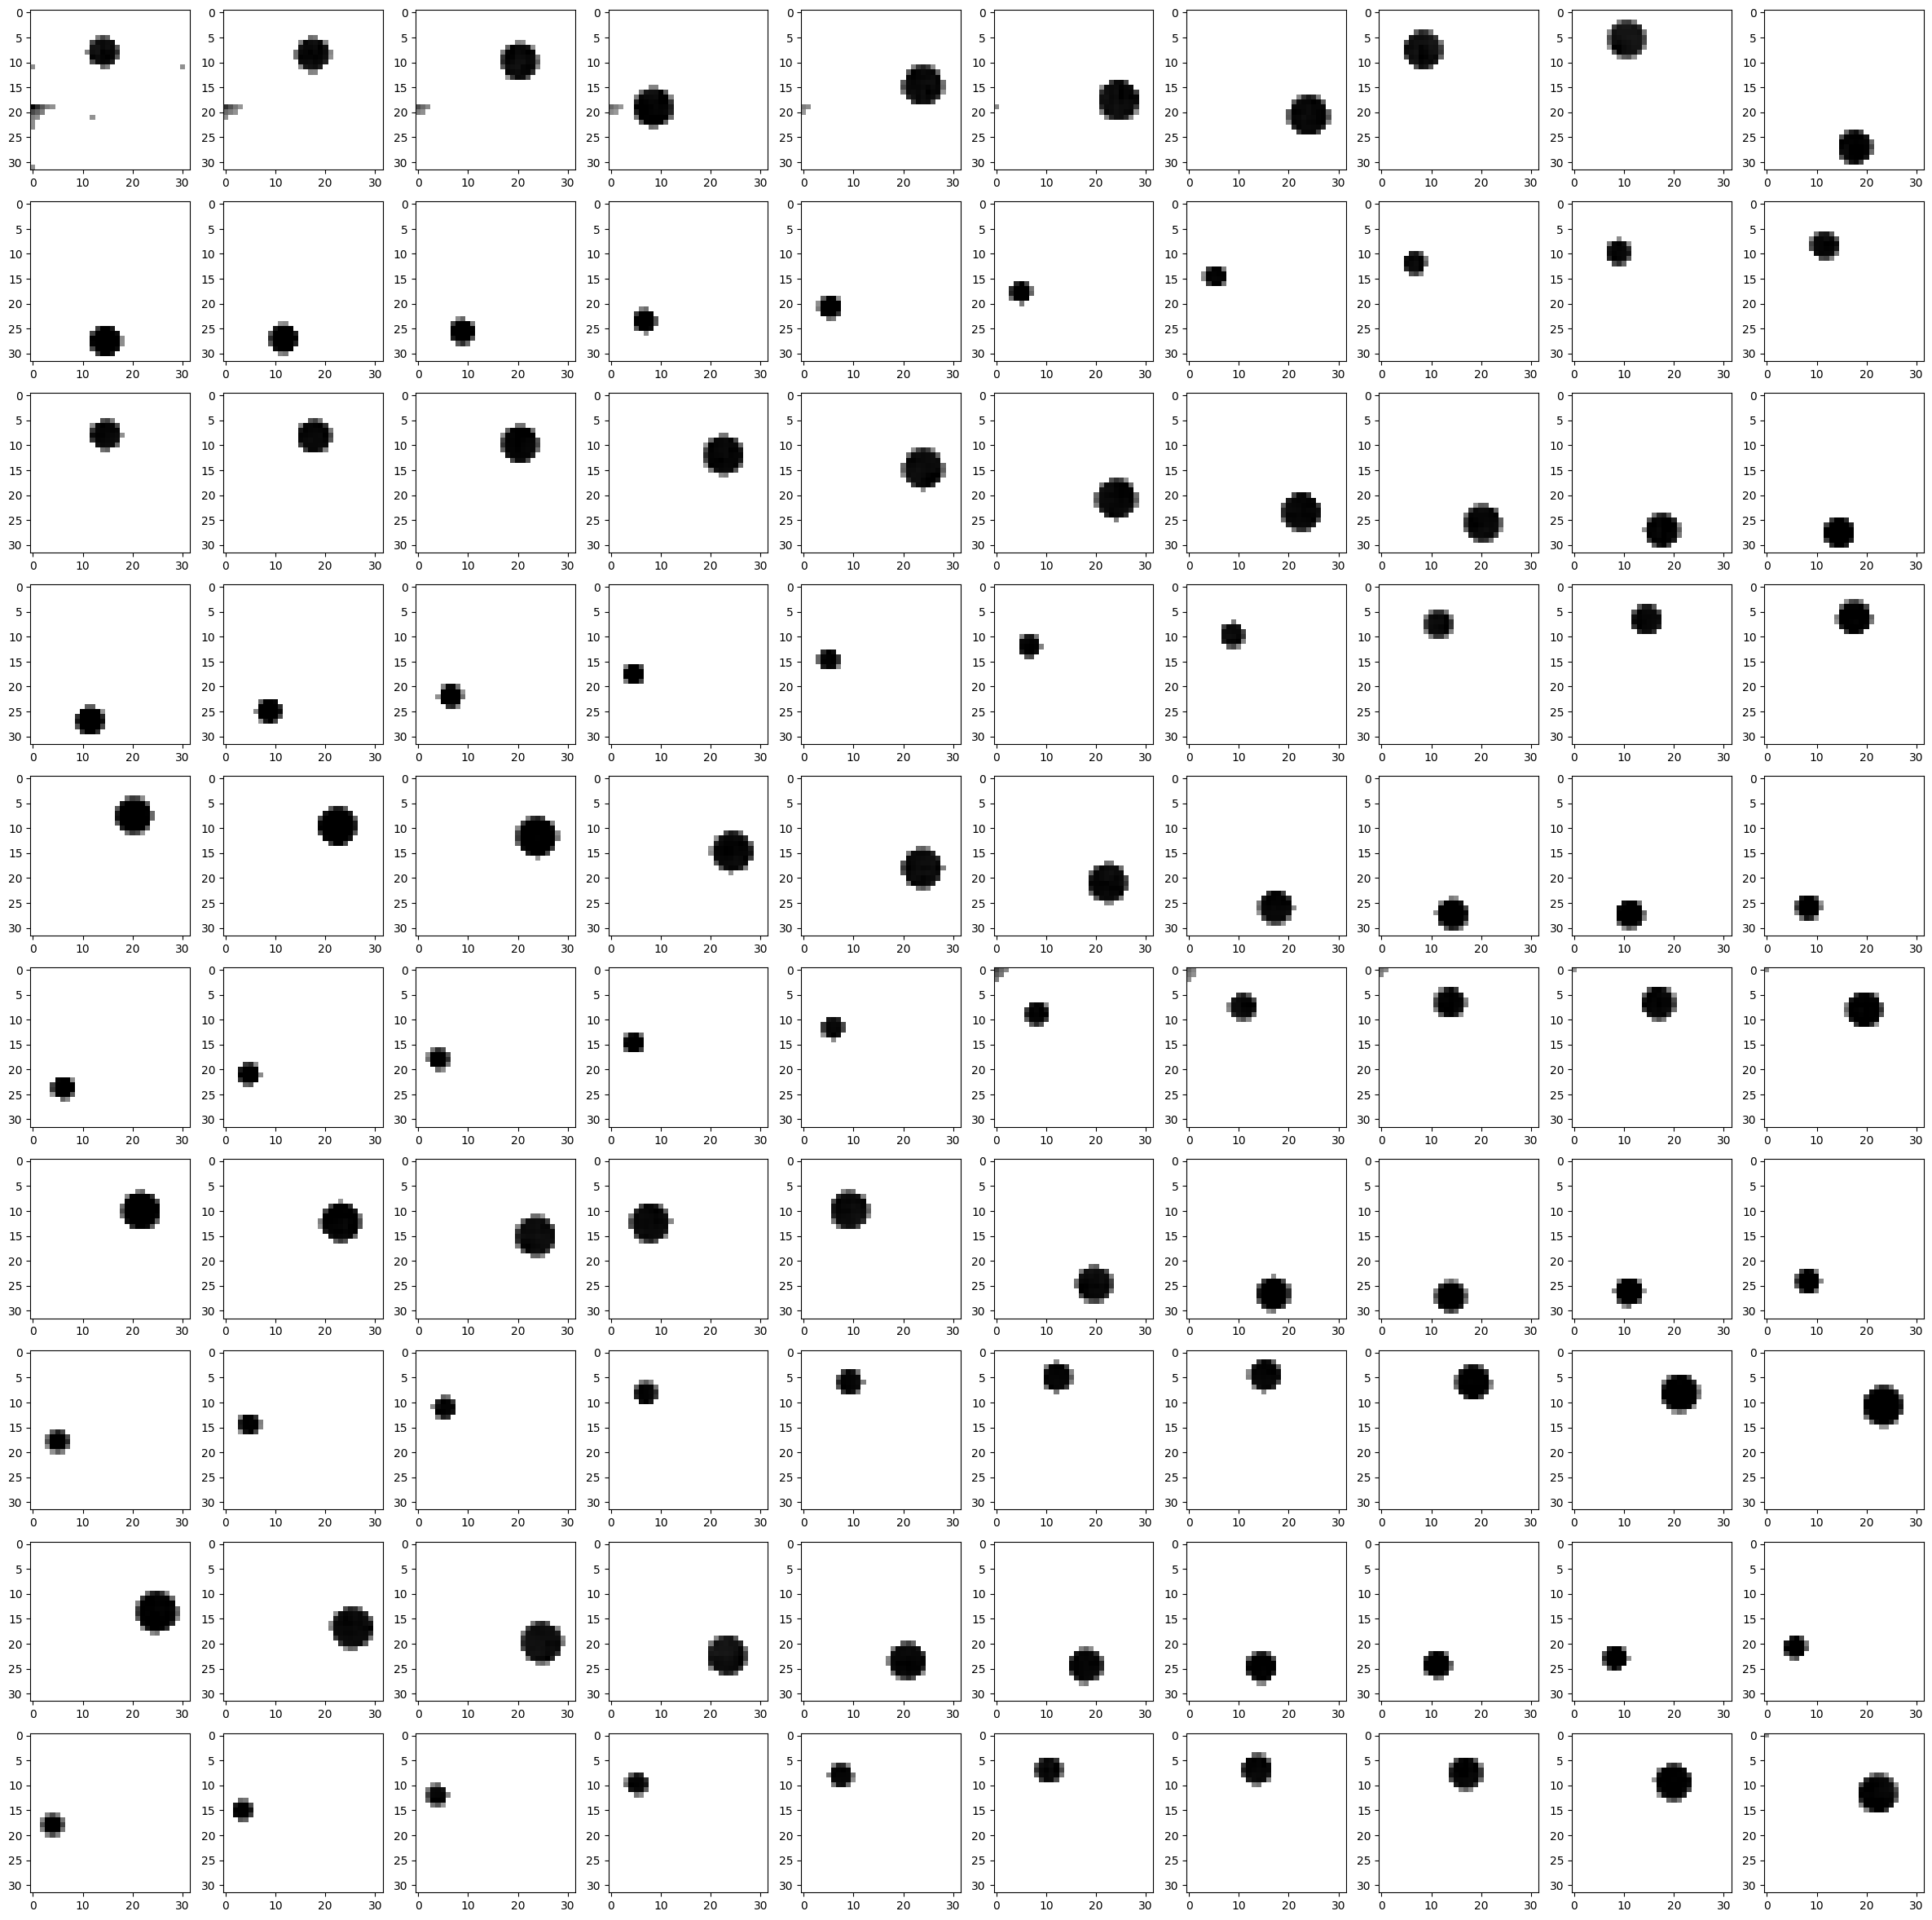

In [22]:
fig, axes = plt.subplots(10, 10, figsize=(30, 30))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(processed_frames):
        ax.imshow(processed_frames[i], cmap='gray')
plt.show()

In [23]:
processed_frames = np.array(processed_frames)

***Model application***

In [24]:
ytr = processed_frames[6:, :]
Xtr = []
for i in range(ytr.shape[0]):
    Xtr.append(np.concatenate((processed_frames[i], processed_frames[i+1], processed_frames[i+2]), axis = 1))
Xtr = np.asarray(Xtr)

In [25]:
Xtr.shape

(15309, 32, 96)

In [26]:
denoised_test = np.array(denoised_test)

In [27]:
denoised_test

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1.

In [28]:
Xtr = np.reshape(Xtr, (Xtr.shape[0], Xtr.shape[1]*Xtr.shape[2]))
ytr = np.reshape(ytr, (ytr.shape[0], ytr.shape[1]*ytr.shape[2]))
Xte = np.reshape(denoised_test, (denoised_test.shape[0], denoised_test.shape[1]*denoised_test.shape[2]))

In [29]:
reg = RandomForestRegressor(n_estimators=45)
reg.fit(Xtr, ytr)

RandomForestRegressor(n_estimators=45)

In [30]:
ypr = reg.predict(Xte)

In [31]:
column_names = ["Id"]
for i in range(32):
    for j in range(32):
        col_name = f'frame_{3}_row_{i}_col_{j}'
        column_names.append(col_name)

In [32]:
ypred = []
for i in range(len(ypr)):
    ypred.append(ypr[i].reshape((32, 32)))

In [33]:
ypred

[array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [0.99093682, 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        ...,
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ]]),
 array([[0.98065359, 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        ...,
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1. 

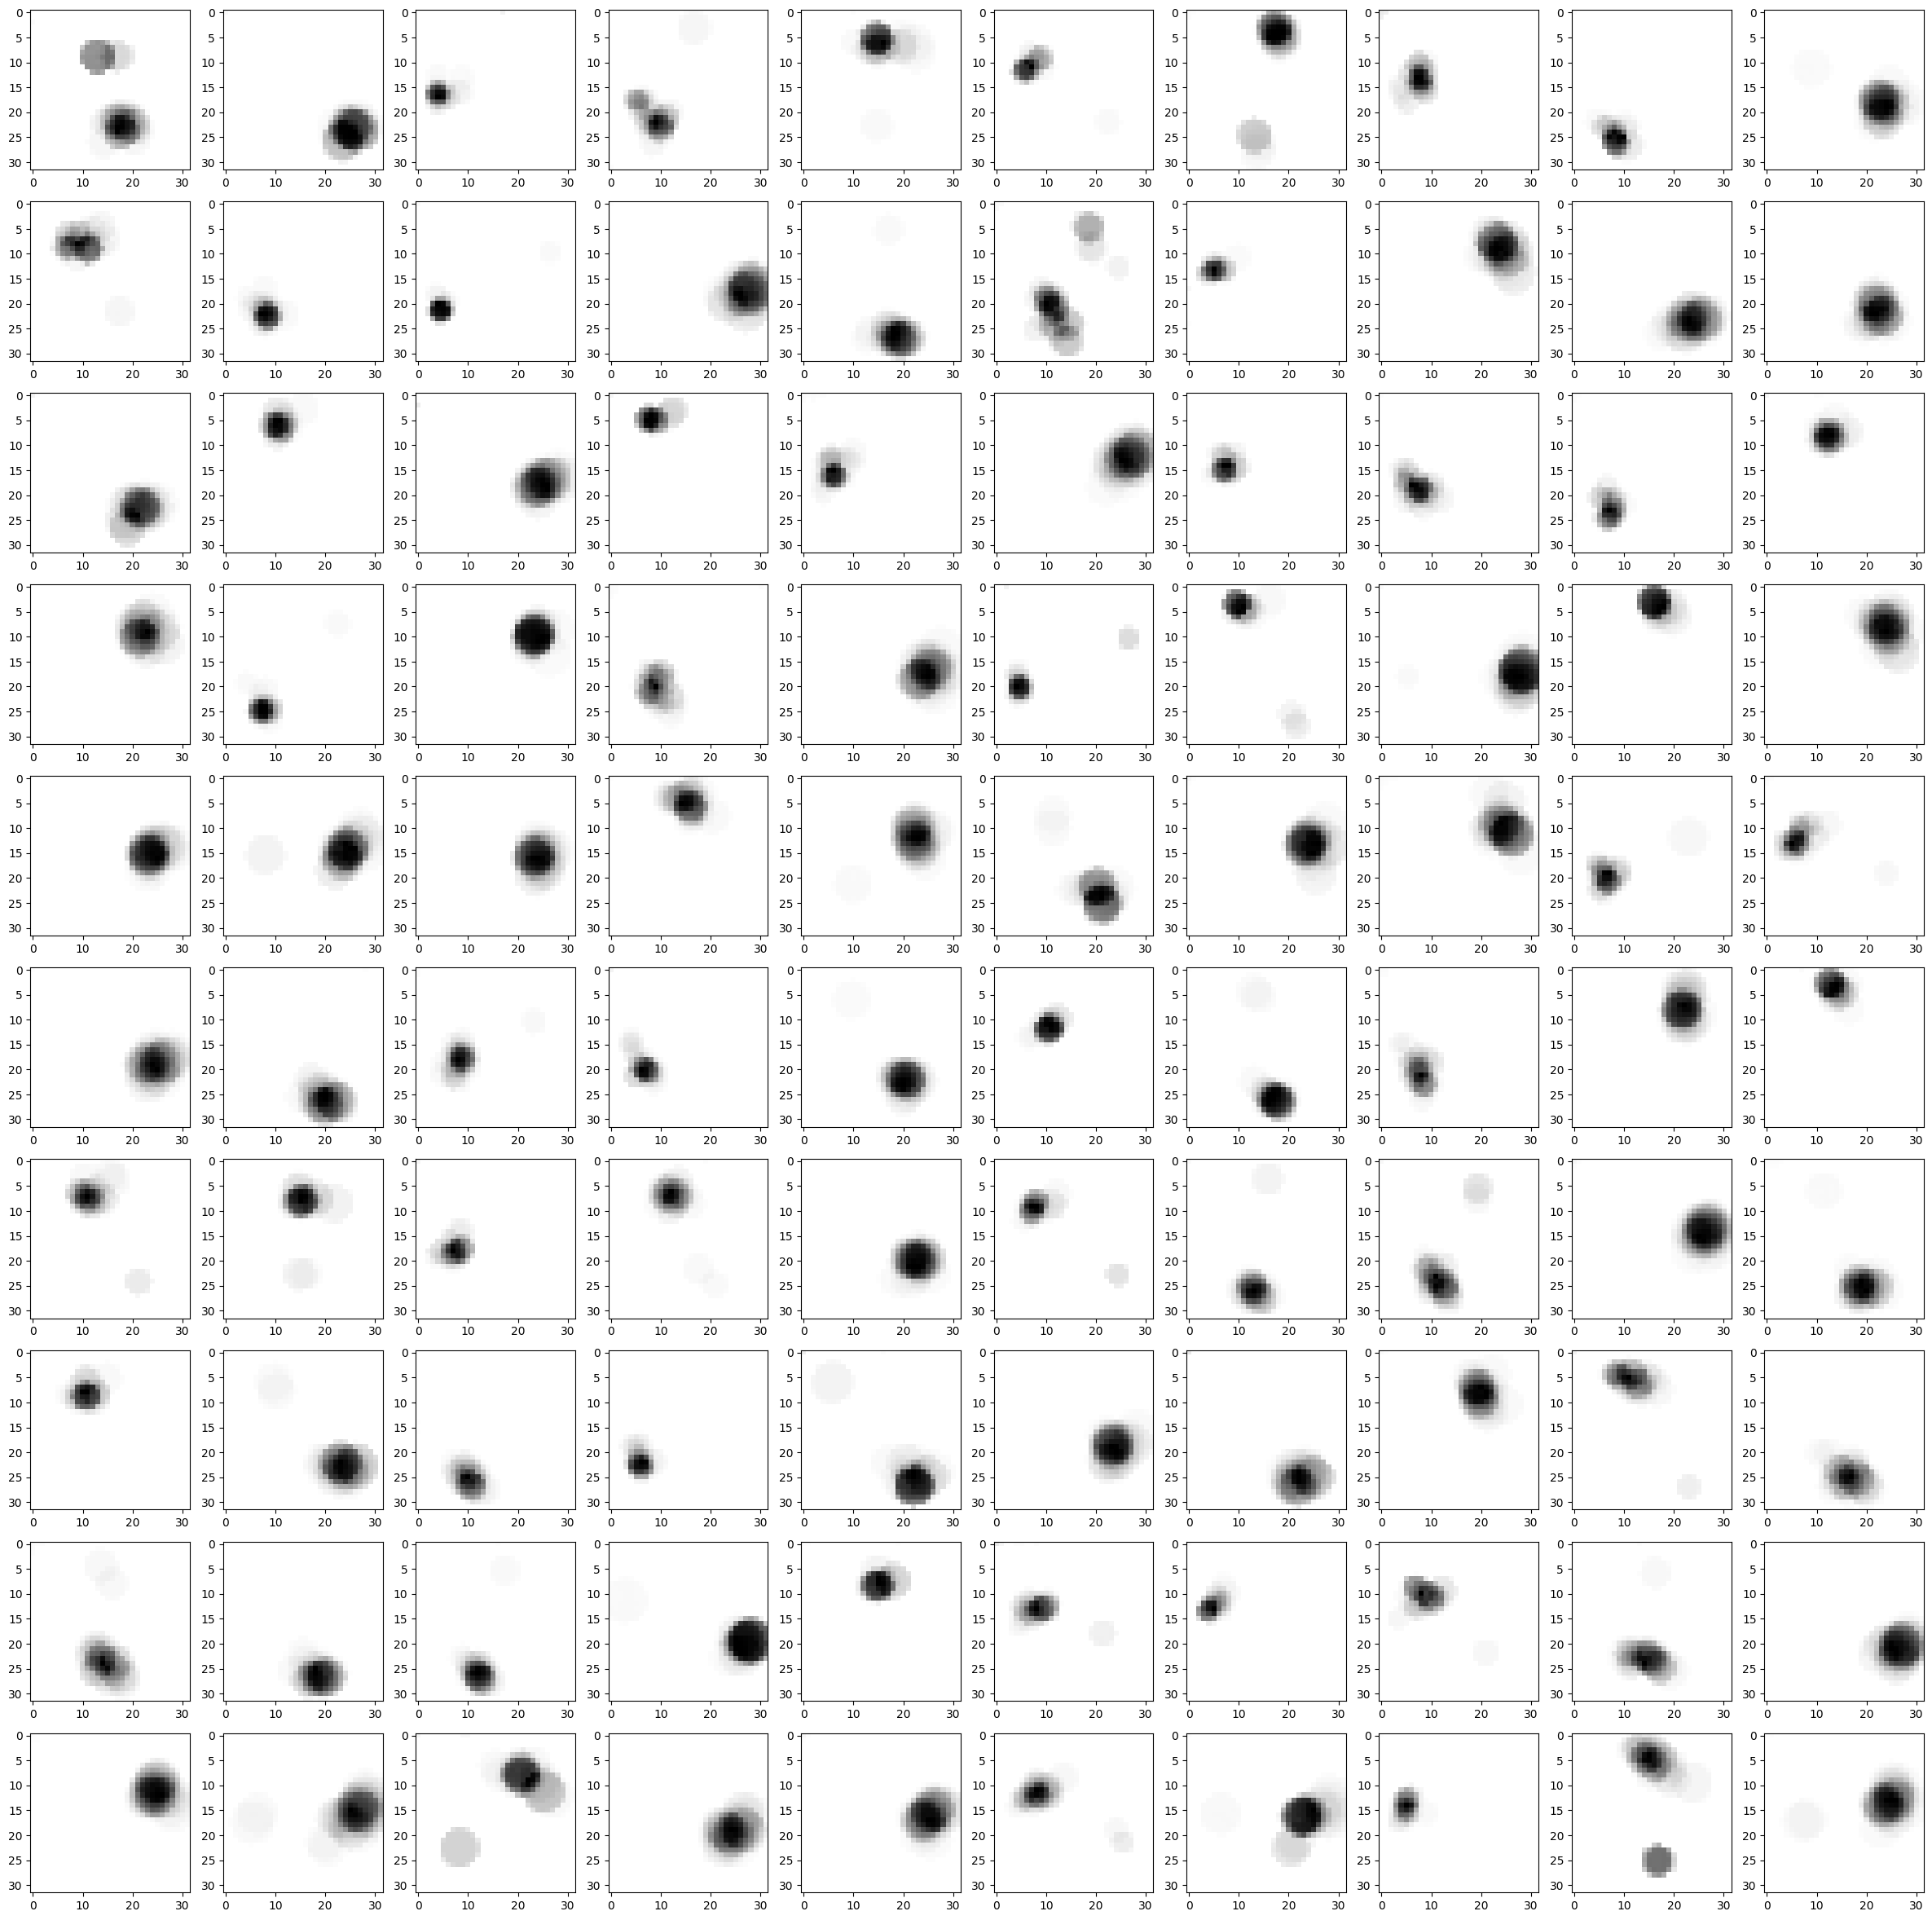

In [34]:
fig, axes = plt.subplots(10, 10, figsize=(30, 30))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(ypred):
        ax.imshow(ypred[i], cmap='gray')
plt.show()

In [35]:
ypr = np.concatenate([np.arange(1, 1+len(ypr)).reshape(-1,1), ypr], axis=1)

In [36]:
df = pd.DataFrame(ypr, columns=column_names)
df["Id"] = df["Id"].astype(int)
df.to_csv("y_test40.csv", index=False)